# Why meteora?

While the API (and especially the underlying code) of meteora may appear rather abstract, the library serves a very simple purpose: making retrieving data from meteorological stations from different sources *as easy as possible* (or at least, this is what we intend).

Let us illustrate the purpose of meteora with a very simple use case. Imagine you want to get meteorological observations for any given region. A good starting point is always [the Global Historical Climatology Network hourly (GHCNh)](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly) dataset:

In [ ]:
import os

import contextily as cx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ultraplot as uplt

from meteora import clients

colors = mpl.colormaps["tab10"].colors
crs = "epsg:4326"
figwidth, figheight = plt.rcParams["figure.figsize"]

aemet_api_key = os.getenv("AEMET_API_KEY", default="")
meteocat_api_key = os.getenv("METEOCAT_API_KEY", default="")
netatmo_client_id = os.getenv("NETATMO_CLIENT_ID", default="")
netatmo_client_secret = os.getenv("NETATMO_CLIENT_SECRET", default="")


def plot_single_axis(client_dict, *, crs=None, ax=None):
    """Plot stations from different clients in a single figure."""
    if crs is None:
        crs = list(client_dict.values())[0].CRS
    if ax is None:
        fig, ax = uplt.subplots()
    pd.concat(
        [
            client_dict[client_label]
            .stations_gdf[["geometry"]]
            .assign(source=client_label)
            .to_crs(crs)
            for client_label in client_dict
        ]
    ).plot("source", legend=True, ax=ax)
    cx.add_basemap(ax, crs=crs, attribution=False)

    return ax


def plot_multi_axes(client_dict, *, col_wrap=2):
    """Plot stations from different clients in a single figure."""
    # prepare subplots
    n_rows = len(client_dict) // col_wrap
    if len(client_dict) % col_wrap != 0:
        n_rows += 1
    fig, axs = uplt.subplots(nrows=n_rows, ncols=col_wrap, share=True)
    for client_label, ax, color in zip(client_dict, axs, colors):
        client = client_dict[client_label]
        client.stations_gdf.to_crs(crs).plot(ax=ax, color=color)
        ax.set_title(client_label)

    # initialize min/max variables
    xmin, xmax = np.inf, -np.inf
    ymin, ymax = np.inf, -np.inf

    # find global limits
    for ax in axs:
        xmin = min(xmin, ax.get_xlim()[0])
        xmax = max(xmax, ax.get_xlim()[1])
        ymin = min(ymin, ax.get_ylim()[0])
        ymax = max(ymax, ax.get_ylim()[1])

    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        cx.add_basemap(ax, crs=crs, attribution=False)

    return fig

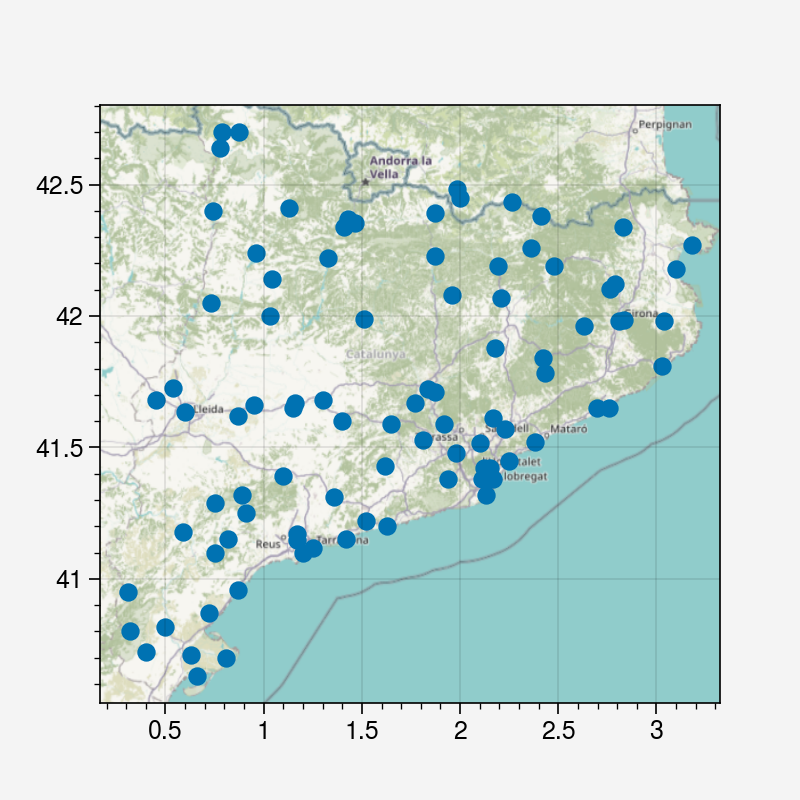

In [ ]:
ghcnh_client = clients.GHCNHourlyClient("Catalunya")
ax = ghcnh_client.stations_gdf.plot()
cx.add_basemap(ax, crs=ghcnh_client.stations_gdf.crs, attribution=False)

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

What if we wanted more stations? In this case, we could also try the [Spanish State Meteorological Agency (AEMET)](https://www.aemet.es) via the `AemetClient`:

SubplotGrid(nrows=1, ncols=1, length=1)

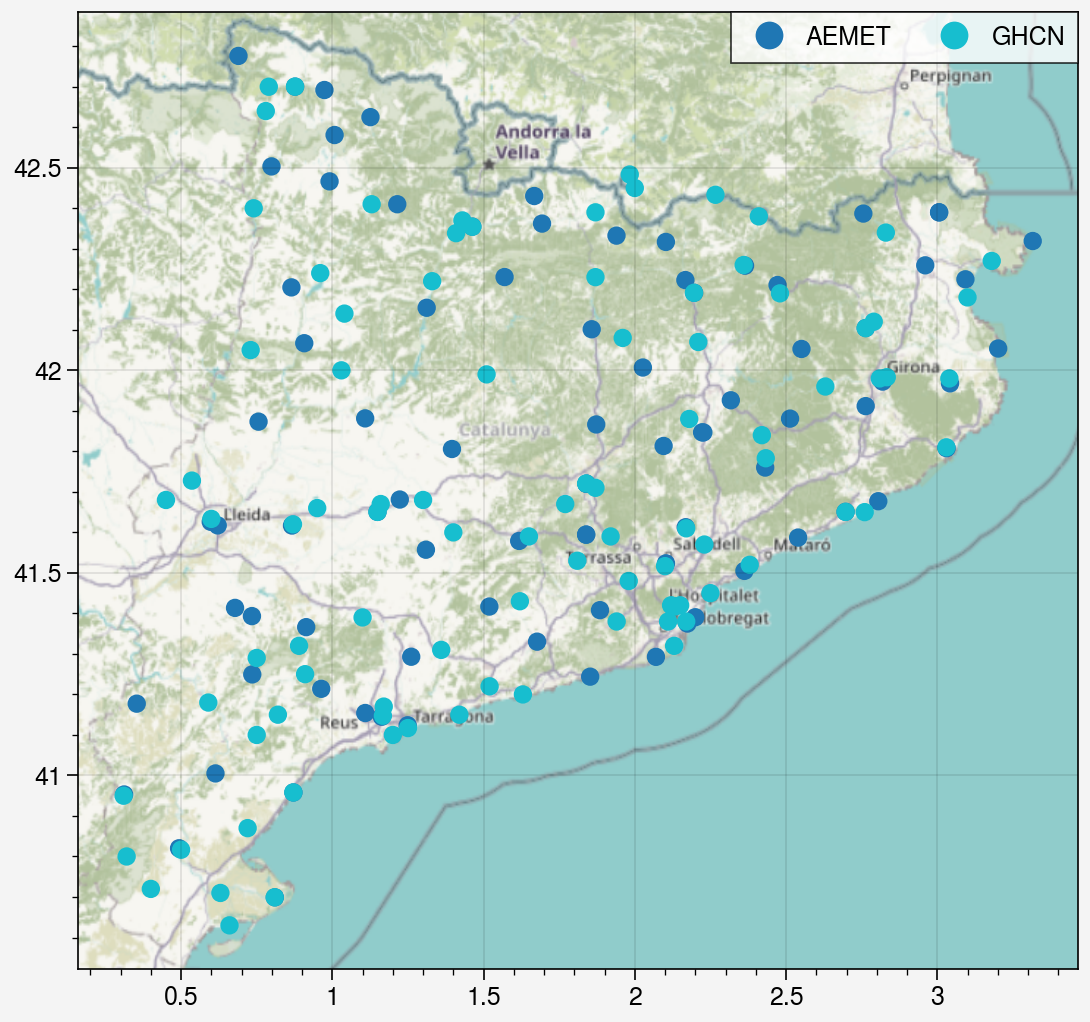

In [ ]:
aemet_client = clients.AemetClient("Catalunya", aemet_api_key)
fig, ax = uplt.subplots(refwidth=5)
plot_single_axis({"AEMET": aemet_client, "GHCN": ghcnh_client}, ax=ax)

As we can see, using both clients improves the spatial density of the stations. What if we wanted even more? well, we could add the [Meteorological Service of Catalonia (Meteocat)](https://en.wikipedia.org/wiki/Meteorological_Service_of_Catalonia) via the `MeteocatClient`:

SubplotGrid(nrows=1, ncols=1, length=1)

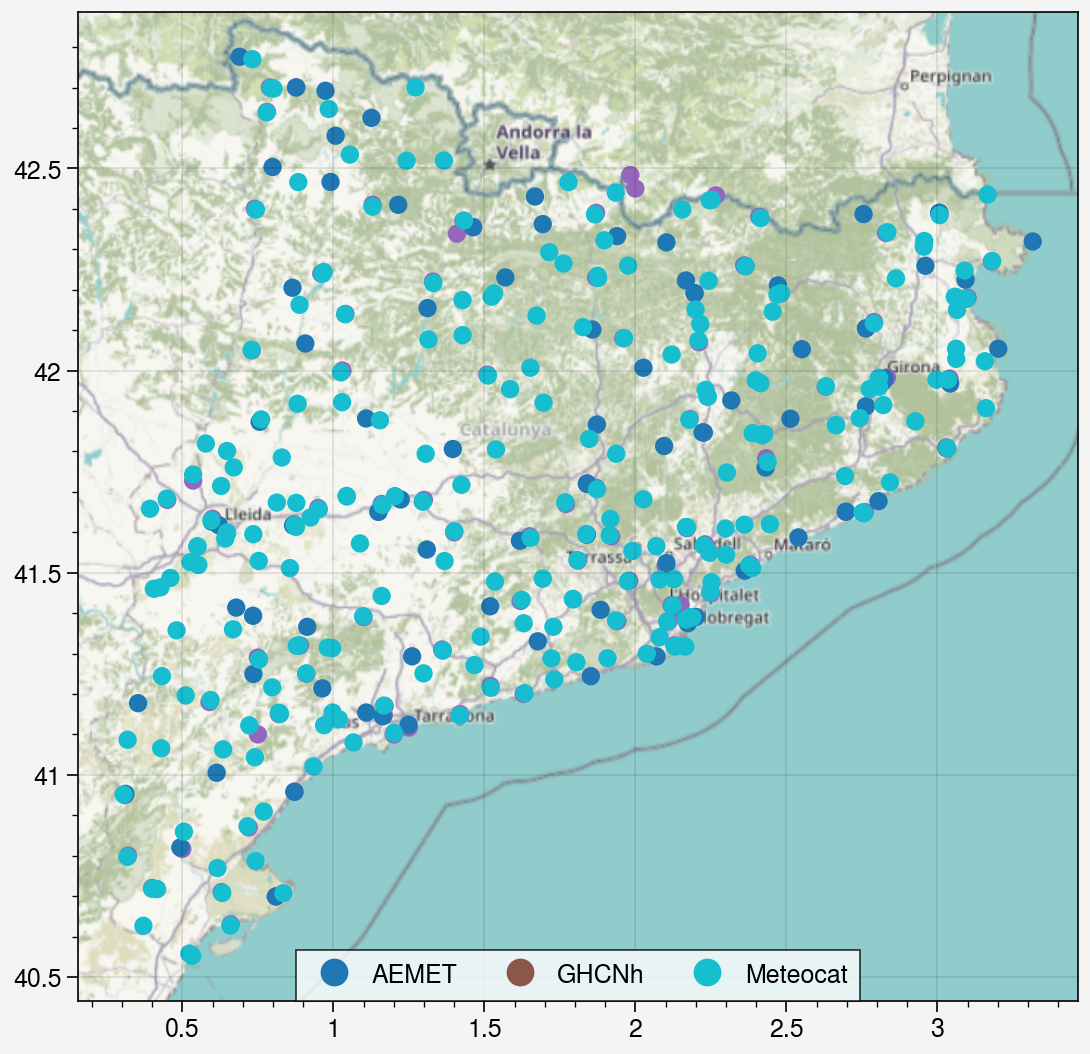

In [ ]:
meteocat_client = clients.MeteocatClient("Catalunya", meteocat_api_key)
cat_client_dict = {
    "GHCNh": ghcnh_client,
    "AEMET": aemet_client,
    "Meteocat": meteocat_client,
}
fig, ax = uplt.subplots(refwidth=5)
plot_single_axis(
    cat_client_dict,
    ax=ax,
)

It is now hard to see GHCNh-colored stations but there is a simple reason for this: most GHCNh stations in the figure actually come from Meteocat data - see "Table 6: Data Source Codes" of the ["README file for the Global Historical Climatology Network hourly (GHCNh) Version 1.0.0"](https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf)). However, if we use separate plots we can see that Meteocat provides data for many stations that are not in GHCNh:

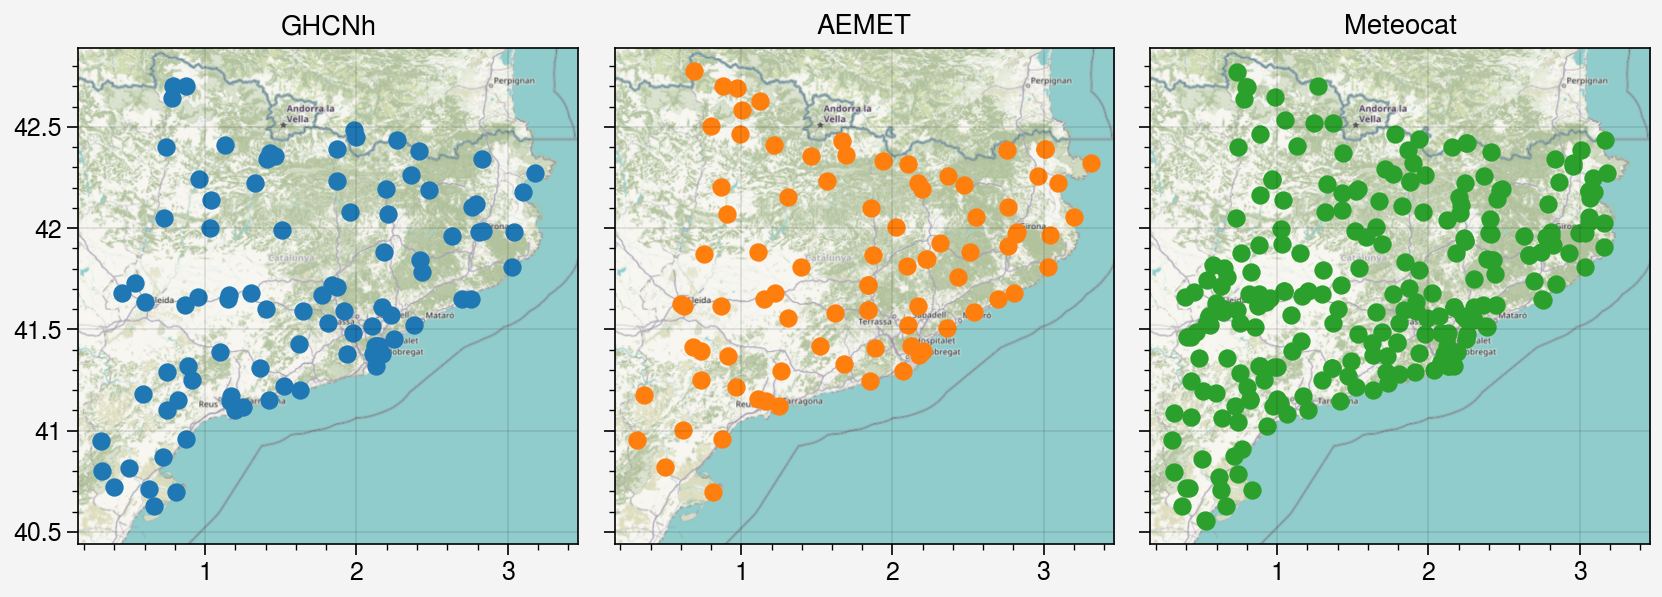

In [ ]:
_ = plot_multi_axes(cat_client_dict, col_wrap=3)

Can we still improve the spatial density of stations? In many cases, yes - enter citizen weather stations (CWS). Meteora features the `NetatmoClient`, which makes it easy to access public data from Netatmo weather stations (one of the major CWS providers). Let us focus on the city of Barcelona:

In [ ]:
region = "Barcelona"
bcn_ghcnh_client = clients.GHCNHourlyClient(region)
bcn_aemet_client = clients.AemetClient(region, aemet_api_key)
bcn_meteocat_client = clients.MeteocatClient(region, meteocat_api_key)
bcn_netatmo_client = clients.NetatmoClient(
    region,
    netatmo_client_id,
    netatmo_client_secret,
)
bcn_client_dict = {
    "GHCNh": bcn_ghcnh_client,
    "AEMET": bcn_aemet_client,
    "Meteocat": bcn_meteocat_client,
    "Netatmo": bcn_netatmo_client,
}

Gtk-Message: 10:36:17.809: Failed to load module "canberra-gtk-module"
Gtk-Message: 10:36:17.814: Failed to load module "canberra-gtk-module"


Opening in existing browser session.


Enter authorization code:  be003902c9808c77396587b11d357d80


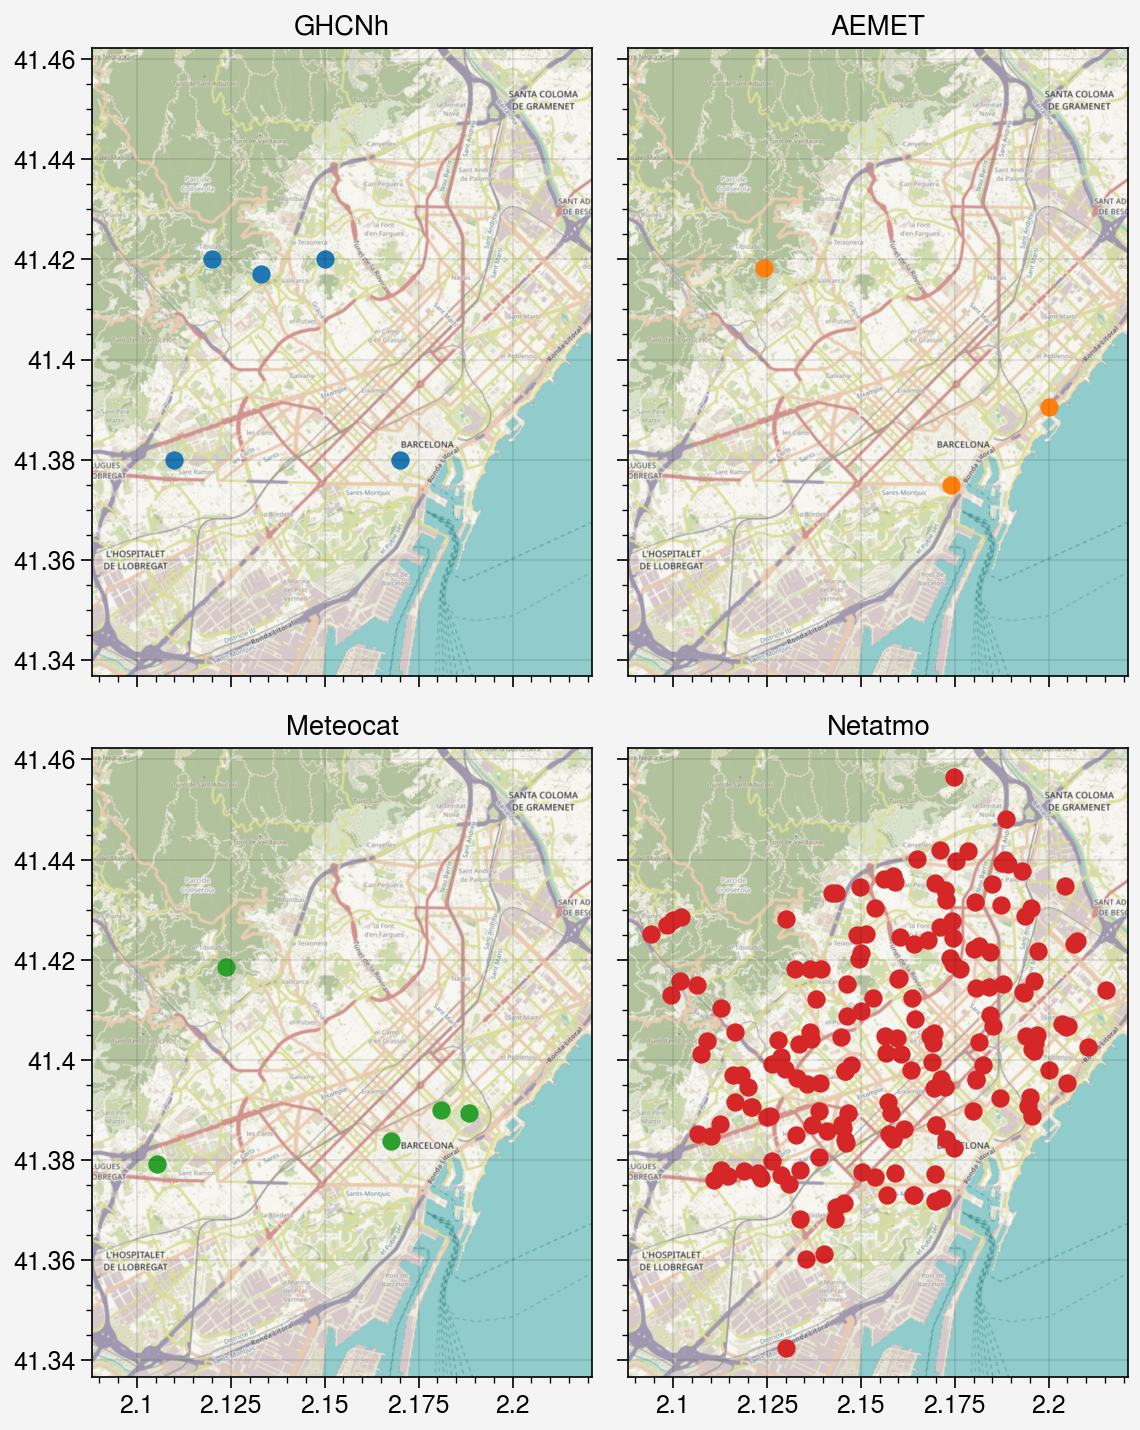

In [ ]:
_ = plot_multi_axes(bcn_client_dict)

As we can see, CWS can vastly improve the spatial density of weather observation, especially in urban areas of Europe and North America. Note that it is strongly recommended to quality-control (QC) CWS data before any climatological analysis - see [a section dedicated to CWS QC with Meteora](https://meteora.readthedocs.io/en/latest/user-guide/netatmo-qc.html) for more details on the subject.

To sum up: despite great standardization efforts of global climatological datasets such as GHCNh, there can be many other sources of meteorological data. *The central objective of meteora is to provide a standardized API and data representation format for meteorological stations data in Python*.

Then, given a list of climate variables and time period of interest, assemble the observations from the above sources into a single data frame:

In [ ]:
variables = ["temperature", "water_vapour"]
start = "08-13-2021"
end = "08-15-2021"

# exclude AEMET since as of Meteora v0.5.0, only the latest 24 hours can be accessed
_bcn_client_dict = bcn_client_dict.copy()
_ = _bcn_client_dict.pop("AEMET")

ts_df = pd.concat(
    [
        _bcn_client_dict[bcn_client_label]
        .get_ts_df(variables, start, end)
        .assign(source=bcn_client_label)
        for bcn_client_label in _bcn_client_dict
    ]
)
ts_df

[########################################] | 100% Completed | 1.47 sms


100%|██████████████████████████████████████████████| 180/180 [00:00<00:00, 486.94it/s]
/tmp/ipykernel_2859593/1815906753.py:9: RuntimeWarning: Cannot compare tz-naive and tz-aware timestamps, sort order is undefined for incomparable objects.
  ts_df = pd.concat(


temperature  water_vapour   source
station_id        time                                                   
SPM00008180       2021-08-13 00:00:00         23.7          93.0    GHCNh
                  2021-08-13 01:00:00         23.7          94.0    GHCNh
                  2021-08-13 02:00:00         23.2          86.0    GHCNh
                  2021-08-13 04:00:00         23.7          90.0    GHCNh
                  2021-08-13 05:00:00         23.2          91.0    GHCNh
...                                            ...           ...      ...
70:ee:50:7f:ca:7c 2021-08-14 21:45:00         28.0          70.0  Netatmo
                  2021-08-14 22:15:00         27.9          69.0  Netatmo
                  2021-08-14 22:45:00         27.7          68.0  Netatmo
                  2021-08-14 23:15:00         27.6          67.0  Netatmo
                  2021-08-14 23:45:00         27.6          67.0  Netatmo

[8279 rows x 3 columns]

As reviewed above, some stations may actually be in GHCNh and Meteocat, so we may be duplicating records. It should be easy to detect duplicates by accessing stations metadata in the `stations_gdf` of each client, but this is beyond the scope of this notebook. Let us conclude by plotting the collected time series of data:

/home/martibosch/miniforge3/envs/meteora/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/home/martibosch/miniforge3/envs/meteora/lib/python3.12/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')


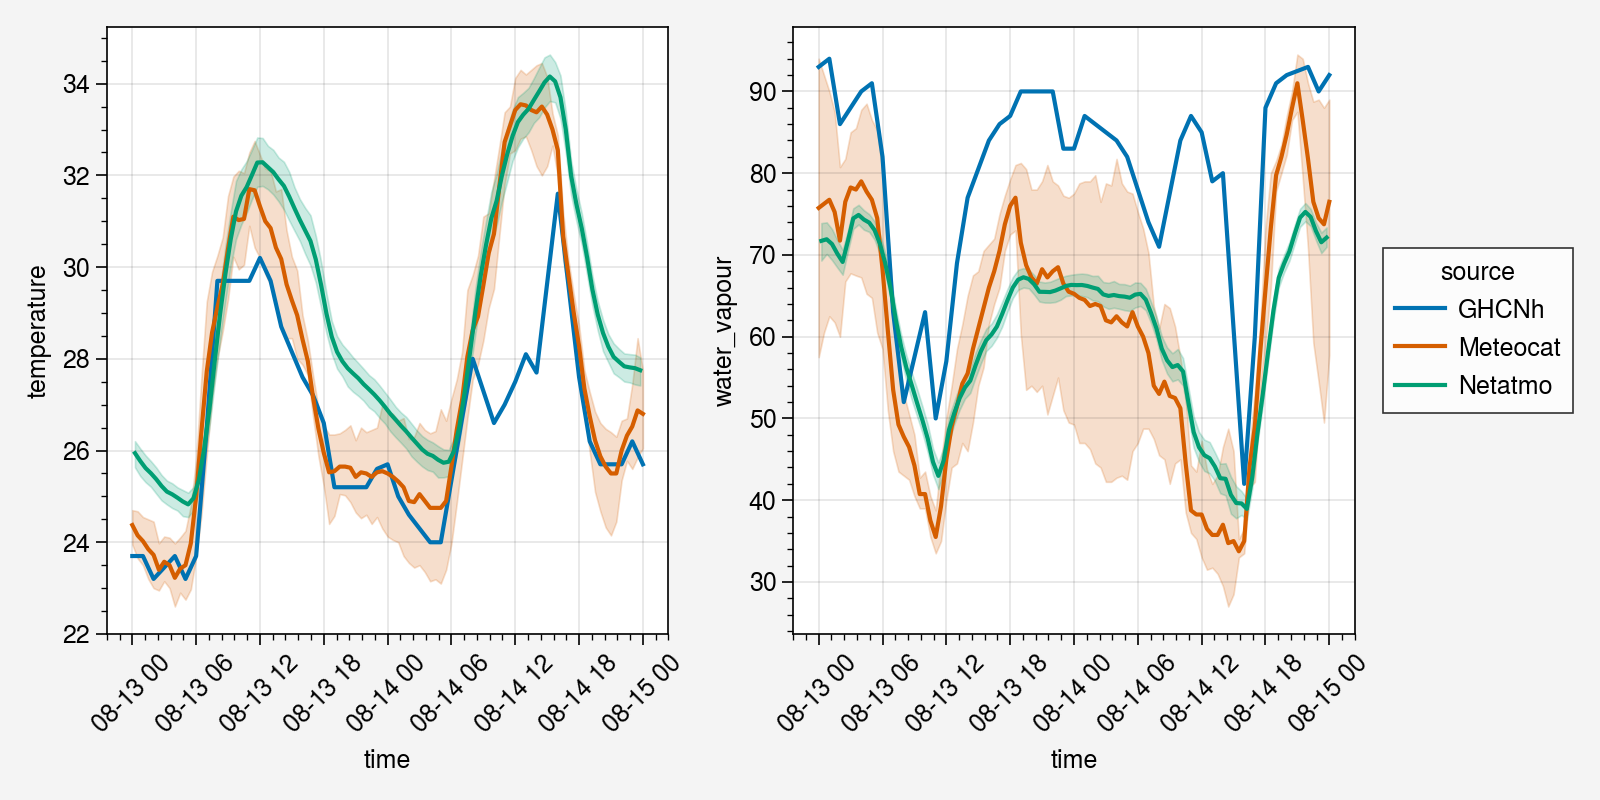

In [ ]:
plot_df = ts_df.reset_index()
fig, axes = plt.subplots(
    ncols=2, sharex=True, sharey=False, figsize=(2 * figwidth, figheight)
)
for variable, ax, legend in zip(variables, axes, [False, True]):
    sns.lineplot(plot_df, x="time", y=variable, hue="source", ax=ax, legend=legend)
    ax.tick_params(axis="x", labelrotation=45)
sns.move_legend(ax, "center left", bbox_to_anchor=(1.05, 0.5))
fig.tight_layout()